# Mumbai Travel time and accessibility analysis

We have data for 3,020 unique ids. **note: the original dataset had 3,135 rows but 115 of them did not have a PIN code for the work destination.** The dataset is named "2019 08 14 Jobs Data from Module 9". 

In addition the first two columns were combined in order to create unique ids. Each id represents a respondent in the survey who commutes to work. 

We are primarily looking to do two kinds of analysis. For both of the analyses described below, we will calculate accessibility according to three modes of transit:
1. OSM road network driving with standard road classes
2. Rail network (known) with walking to the rail station
3. A combined rail and road network with the option of taking both forms of transportation
 
First, identify the households which have individual work places identified by PIN code (There are 107 PIN codes), and calculate their travel time. The second analysis is for every geocoded household, calculate job accessibilitiy indices.

1. Distance from residence to work place; estimated travel time (analysis 1)
          a. Calculate distance from house to workplace using (i) road network; (ii) rail network 
          b. Calculate travel time via road network and rail network
          c. Calculate travel time via walking
          d. Calculate Euclidean distance from house to workplace for each worker 

**note that not all the households could be matched to PIN codes, for example, there is no 400000 PIN code in the dataset.**

2. Index of employment accessibility (analysis 2)
          a. In addition to the information in 2., we have information on employment, by gender and industry for 99 Sections of Mumbai.
          b. We would like to combine this information with household location information from the survey to calculate an index of employment accessibility (separate index for men and women) for each household in the sample. The index would measure number of jobs accessible based on a weighted gravity model. 
          c. We are also calculating the number of jobs accessible per household based on three travel windows (30 min, 60 min, and 90 min).


### The parameters are used in our model:

- metroSpeed = 35 #kph
- railSpeed = 40 #kph
- station_wait = 30 #seconds
- walk_speed = 5 #kph

## import libraries

In [141]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [142]:
# Get reference to GOSTNets
sys.path.append(r'/home/vagrant/repos/GOST_PublicGoods/')
from Market_Access import OSMNX_POIs

In [143]:
sys.path.append(r'/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets')
import GOSTnet as gn

In [144]:
# Get reference to GOSTRocks
sys.path.append(r'/media/sf_data')
from GOSTRocks import misc
from GOSTRocks import osmMisc
urbanParams = misc.getUrbanParams()

In [145]:
# Define input data and create a number of output datasets if they do not yet exist
inputFolder = r'/media/sf_data/Mumbai_OD'

inHouseholds = os.path.join(inputFolder, "_new_data", "2019_08_14_households_and_destinations_reformatted3.csv")

# not using employment by section data for for analysis 1
inJobDefinition = os.path.join(inputFolder, "employment by section.csv")
inJobs_by_section = os.path.join(inputFolder, "GOST_Data", "revised_data/greater_mumbai_merged.shp")
inJobs = os.path.join(inputFolder, "_new_data", "mumbai_pin_codes/mumbai_pin_codes.shp")

inputRailways = os.path.join(inputFolder, 'GOST_Data', "revised_data/Mumbai_Railway_MANUAL_43N/Mumbai_Railway_MANUAL_43N.shp")
inputRailstops = os.path.join(inputFolder, 'GOST_Data', "revised_data/Mumbai_Railway_stations_MANUAL2/Mumbai_Railway_stations_MANUAL.shp")

# Read in the Section admin boundaries and extract the centroids
inJ_by_section = gpd.read_file(inJobs_by_section)
inJD_by_section = pd.read_csv(inJobDefinition)
inJ_by_section = pd.merge(inJ_by_section, inJD_by_section, left_on="WARD_NO", right_on="section")
inJ_cen_by_section = inJ_by_section.copy()
inJ_cen_by_section['geometry'] = inJ_cen_by_section.centroid

# Read in the PIN admin boundaries and extract the centroids
inJ_by_pin = gpd.read_file(inJobs)
inJ_cen_by_pin = inJ_by_pin.copy()
inJ_cen_by_pin['geometry'] = inJ_cen_by_pin.centroid

outputFolder = os.path.join(inputFolder, "GOST_Data")
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

outRoads = os.path.join(outputFolder, "OSM_Roads.csv")
outGraph = os.path.join(outputFolder, "OSM_Roads.pickle")
outRailGraph = os.path.join(outputFolder, "OSM_Rail.pickle")
outComboGraph = os.path.join(outputFolder, "OSM_Combo.pickle")

In [146]:
# original speed dict
speed_dict = {
               'residential': 20,  # kmph
               'primary': 40, # kmph
               'primary_link':35,
               'motorway':50,
               'motorway_link': 45,
               'trunk': 40,
               'trunk_link':35,
               'secondary': 30,
               'secondary_link':25,
               'tertiary':30,
               'tertiary_link': 25,
               'unclassified':20
               }
# the default speed if no match is 20kph

### calculate speeds using original speed dictionary

In [147]:
# This is the section where we can adjust the road speeds
if not os.path.exists(outGraph):
    extent = box(*inJ.total_bounds)
    G = ox.graph_from_polygon(extent, network_type='drive_service')
    # This is how time is calculated from the OSMNX length attribute
    #G = gn.convert_network_to_time(G, 'length')
    G = gn.convert_network_to_time(G, 'length', speed_dict=speed_dict)
    nx.write_gpickle(G, outGraph)
    roads = gn.edge_gdf_from_graph(G)
    roads['highway'] = roads.highway.astype(str)
    roads['OSMLR'] = roads.highway.map(osmMisc.OSMLR_Classes)
    roads['oneway'] = roads.oneway.astype(int) 
    roads.to_file(outRoads)
else:
    G = nx.read_gpickle(outGraph)    
    #G = gn.convert_network_to_time(G, 'length')
    G = gn.convert_network_to_time(G, 'length', speed_dict=speed_dict)

In [148]:
# find the average speed of the road graph
gn.find_graph_avg_speed(G, 'length', 'time')

22.1810389522122

In [149]:
#15kph peak
#16.5kph avg speed
#20kph off-peak
#22.1810389522122 * x = 15
print(15/22.1810389522122)

0.6762532644352979


In [150]:
peak_ratio = 15/22.1810389522122
avg_speed_ratio = 16.5/22.1810389522122
off_peak_ratio = 20/22.1810389522122

In [151]:
# find all classes of highways
highway_classes = gn.find_hwy_distances_by_class(G)
highway_classes

{'residential': 2891749.8950000186,
 'unclassified': 2067915.367999996,
 'tertiary': 801446.0129999997,
 'primary': 306935.18900000013,
 'secondary': 587354.8119999977,
 'motorway': 50689.78399999998,
 'living_street': 254135.7070000001,
 'trunk': 189441.8309999999,
 'service': 636710.9099999986,
 'trunk_link': 43585.77000000004,
 'primary_link': 14967.872,
 'secondary_link': 3316.1130000000003,
 'motorway_link': 9329.546999999999,
 'tertiary_link': 2826.961,
 'road': 1387.336}

In [152]:
speed_peak_dict = {}
speed_avg_dict = {}
speed_off_peak_dict = {}

In [153]:
for key in speed_dict:
    speed_peak_dict[key] = speed_dict[key] * peak_ratio
    speed_avg_dict[key] = speed_dict[key] * avg_speed_ratio
    speed_off_peak_dict[key] = speed_dict[key] * off_peak_ratio 

In [154]:
# add living_street, service, and road
speed_peak_dict_default_speed = 20 * peak_ratio
speed_peak_dict['living_street']=speed_peak_dict_default_speed
speed_peak_dict['service']=speed_peak_dict_default_speed
speed_peak_dict['road']=speed_peak_dict_default_speed

speed_avg_dict_default_speed = 20 * avg_speed_ratio
speed_avg_dict['living_street']=speed_avg_dict_default_speed
speed_avg_dict['service']=speed_avg_dict_default_speed
speed_avg_dict['road']=speed_avg_dict_default_speed
  
speed_off_peak_dict_default_speed = 20 * off_peak_ratio
speed_off_peak_dict['living_street']=speed_off_peak_dict_default_speed
speed_off_peak_dict['service']=speed_off_peak_dict_default_speed
speed_off_peak_dict['road']=speed_off_peak_dict_default_speed

In [155]:
speed_peak_dict

{'residential': 13.525065288705957,
 'primary': 27.050130577411913,
 'primary_link': 23.668864255235427,
 'motorway': 33.81266322176489,
 'motorway_link': 30.431396899588403,
 'trunk': 27.050130577411913,
 'trunk_link': 23.668864255235427,
 'secondary': 20.287597933058937,
 'secondary_link': 16.906331610882447,
 'tertiary': 20.287597933058937,
 'tertiary_link': 16.906331610882447,
 'unclassified': 13.525065288705957,
 'living_street': 13.525065288705957,
 'service': 13.525065288705957,
 'road': 13.525065288705957}

In [156]:
speed_avg_dict

{'residential': 14.877571817576554,
 'primary': 29.755143635153107,
 'primary_link': 26.03575068075897,
 'motorway': 37.19392954394139,
 'motorway_link': 33.47453658954725,
 'trunk': 29.755143635153107,
 'trunk_link': 26.03575068075897,
 'secondary': 22.31635772636483,
 'secondary_link': 18.596964771970693,
 'tertiary': 22.31635772636483,
 'tertiary_link': 18.596964771970693,
 'unclassified': 14.877571817576554,
 'living_street': 14.877571817576554,
 'service': 14.877571817576554,
 'road': 14.877571817576554}

In [157]:
speed_off_peak_dict

{'residential': 18.033420384941277,
 'primary': 36.06684076988255,
 'primary_link': 31.558485673647233,
 'motorway': 45.08355096235319,
 'motorway_link': 40.57519586611787,
 'trunk': 36.06684076988255,
 'trunk_link': 31.558485673647233,
 'secondary': 27.050130577411913,
 'secondary_link': 22.541775481176597,
 'tertiary': 27.050130577411913,
 'tertiary_link': 22.541775481176597,
 'unclassified': 18.033420384941277,
 'living_street': 18.033420384941277,
 'service': 18.033420384941277,
 'road': 18.033420384941277}

## Manually switch out what speed dictionary you are using in your analysis here

In [158]:
# This is the section where we can adjust the road speeds
G = nx.read_gpickle(outGraph)    
#G = gn.convert_network_to_time(G, 'length')
G = gn.convert_network_to_time(G, 'length', speed_dict=speed_peak_dict)

In [159]:
# double-check the road graph G
gn.example_edge(G, 3)

(2248802304, 2248802330, {'osmid': 215438684, 'oneway': False, 'length': 66.863, 'highway': 'residential', 'time': 17.797089689541174, 'mode': 'drive'})
(2231177689, 2231177714, {'osmid': 50889068, 'highway': 'unclassified', 'name': 'Killeshwar Mahadev Mandir Marg', 'oneway': False, 'length': 75.801, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c56b51208>, 'time': 20.176139203399647, 'mode': 'drive'})
(2231177689, 2231177588, {'osmid': 213417598, 'highway': 'unclassified', 'oneway': False, 'length': 290.38200000000006, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c574ec208>, 'time': 77.29169343625544, 'mode': 'drive'})


In [160]:
# find the average speed of the road graph
gn.find_graph_avg_speed(G, 'length', 'time')

14.999999999999734

### Inspect the input graph from OSMNX to see the input road edges and nodes

In [161]:
from shapely.wkt import loads

In [162]:
df = pd.read_csv(outRoads, encoding='utf-8')

/home/vagrant/miniconda3/envs/GOST_PublicGoods4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [163]:
geometry = [loads(x) for x in df.geometry]
print(geometry[0])
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='outroads2.shp',encoding='utf-8')

LINESTRING (72.9334716 19.0543562, 72.93290450000001 19.0546287)


In [164]:
from shapely.geometry import Point
g_point_gdf = gn.node_gdf_from_graph(G,crs = {'init' :'epsg:4326'})
#g_point_gdf = g_point_gdf.drop(columns=['geom'])
g_point_gdf
g_point_gdf.to_file(driver = 'ESRI Shapefile', filename = inputFolder+'/outroads_nodes2.shp')

## Generate the rail network part I
#### This takes in the input railways and converts it to a geodataframe of points. Then the input station points are snapped to these points and the geometries of the stations get changed to match the geometry of the point it was snapped to

In [165]:
#if not os.path.exists(outRailGraph):
#Read in the input railways check for problems, and project
inR = gpd.read_file(inputRailways)
inR = inR[[r is not None for r in inR.geometry]]
if inR.crs == {'init':'epsg:4326'}:
    #inR = misc.project_UTM(inR)
    print('skip')
inR = inR.to_crs({'init': 'epsg:32643'})

# line below not needed because length will be generated at a later step
#inR['length'] = inR['geometry'].apply(lambda x: x.length)

#Read in the railway stations and project
inS = gpd.read_file(inputRailstops)
inS = inS[inS['railway'] == "station"]

inS_proj = inS.to_crs({'init': 'epsg:32643'})
print('check projection inS')
print(inS_proj.crs)

print('check projection inR')
print(inR.crs)

#Generate the Rail network from the rail shapefile
allRailLines = unary_union(inR['geometry'])

# deconstructing the rail network into a geodataframe of points
bag_of_points,ids = [],[]
id_ = 0
for r in allRailLines.geoms:
    for q in r.coords:
        bag_of_points.append(q)
        ids.append(id_)
        id_+=1

df_temp = pd.DataFrame(({'ids':ids,'geometry':bag_of_points}))
df_temp['geometry'] = df_temp['geometry'].apply(Point)
gdf_temp = gpd.GeoDataFrame(df_temp, crs = inR.crs, geometry = 'geometry')

# for testing temporarily export rail bag of points
#gdf_temp.to_file(driver = 'ESRI Shapefile', filename = 'pre_railine_points3.shp' )

# for testing temporarily export rail stations
#inS_proj.to_file(driver = 'ESRI Shapefile', filename = 'pre_station_points3.shp' )

# the source_crs should be the same proj as both the input graph and input geodataframe of points
# the rail points need to be snapped to the rail because later the snapped points will be used to split the rail
inS_proj_snapped = gn.pandana_snap_points(inS_proj, 
                                          gdf_temp, 
                                          source_crs = 'epsg:32643', 
                                          target_crs = 'epsg:32643',
                                          add_dist_to_node_col = True)
inS_proj_snapped_temp = inS_proj_snapped.drop_duplicates('NN')

# I think that when the rail stations got snapped to the nearest node in the dataframe it is keeping the original geometry
# but it is adding the NN id and the NN_distance

# Therefore join to the Rail gdf to add the geometries of the nodes snapped to
inS_proj_snapped_temp = inS_proj_snapped_temp.rename(columns={"geometry": "original_geometry"})
inS_proj_snapped_temp_joined = inS_proj_snapped_temp.set_index('NN').join(gdf_temp.set_index('ids'))
inS_proj_snapped_temp_joined = inS_proj_snapped_temp_joined.reset_index()

# note when I had both original_geometry and geometry columns there was an error in outputting a shapefile
# it must have been confused with two geometry columns, therefore I am dropping the 'original_geometry' column
inS_proj_snapped_temp_joined_slim = inS_proj_snapped_temp_joined.drop(columns="original_geometry")
inS_proj_snapped_temp_joined_slim

#inS_proj_snapped_temp.keys()

inS_proj_snapped_temp_joined_geo = gpd.GeoDataFrame(inS_proj_snapped_temp_joined_slim, crs = inS_proj.crs, geometry = 'geometry')
# preview the snapped rail stations
inS_proj_snapped_temp_joined_geo.to_file(driver = 'ESRI Shapefile', filename = 'snapped_rail_stations3.shp')

check projection inS
{'init': 'epsg:32643'}
check projection inR
{'init': 'epsg:32643'}


/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets/GOSTnet.py:1770: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(target_gdf[['x','y']].as_matrix())
/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets/GOSTnet.py:1772: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(source_gdf[['x','y']].as_matrix())


In [166]:
inS_proj_snapped_temp_joined_geo[:2]

,NN,full_id,osm_id,osm_type,name,network,railway,ref,wikidata,wikipedia,...,short_name,constructi,disused,proposed,alt_name_h,name_pa,highway,traffic_si,NN_dist,geometry
0,291,n213030669,213030669,node,Dahisar,None,station,DIC,Q5208848,en:Dahisar railway station,...,None,None,None,None,None,None,None,None,27.096695,POINT (275001.0781111507 2129854.901504612)
1,627,n213030714,213030714,node,Santacruz,IR,station,STC,Q7420001,en:Santacruz railway station,...,None,None,None,None,None,None,None,None,37.092462,POINT (272926.0703397002 2111281.305015021)


## Generate the rail network Part II
#### The allRailLines are the result of a unary union on the railway lines. Therefore they are only multiLine geometries without any attribution. The snapped railway stations also undergo a unary union and are now multiPoint. allRailLines gets split by the snapped railway stations and all the parts are put back together creating a MultiDiGraph.

In [167]:
bag_of_relevant_points = unary_union(inS_proj_snapped_temp_joined_geo.geometry)

# a shapely.ops function
split_geoms = split(allRailLines, bag_of_relevant_points)

print('print count of split geometries')
print(len(split_geoms))

geom_bag = []

for geom in split_geoms:
    g = geom.coords[0]
    h = geom.coords[-1]
    geom_bag.append(str(g))
    geom_bag.append(str(h))

ref = pd.DataFrame({'node_ids':range(0, len(geom_bag)),'geoms':geom_bag})
ref = ref.drop_duplicates('geoms')
ref = ref.set_index('geoms')

nodes = []
edges = []

for geom in split_geoms:
    u_data,v_data,edge_data = {},{},{}

    # start node
    # it is getting a reference to that node's coords
    u = ref['node_ids'].loc[str(geom.coords[0])]
    u_data['x'] = geom.coords[0][0]
    u_data['y'] = geom.coords[0][1]
    u_data['geom'] = Point(geom.coords[0])
    #u_data['string'] = str(geom.coords[0])

    # end node
    v = ref['node_ids'].loc[str(geom.coords[-1])]
    v_data['x'] = geom.coords[-1][0]
    v_data['y'] = geom.coords[-1][1]
    v_data['geom'] = Point(geom.coords[-1])
    #v_data['string'] = str(geom.coords[-1])

    # edge
    edge_data['geom'] = geom
    edge_data['length'] = geom.length
    #edge_data['rail_type'] = geom.rail_type

    nodes.append((u,u_data))
    nodes.append((v,v_data))
    edges.append((u,v,edge_data))
    edges.append((v,u,edge_data))

    id_ += 2

G_rail = nx.MultiDiGraph()
G_rail.add_nodes_from(nodes)
G_rail.add_edges_from(edges)
nx.write_gpickle(G_rail, outRailGraph)
#else:
    #G_rail = nx.read_gpickle(outRailGraph) 

print count of split geometries
91


#### you can see below that the edges only have the geometry and the length attributes

In [168]:
gn.example_edge(G_rail, 2)

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972be0>, 'length': 1388.5881250266957})
(1, 0, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972be0>, 'length': 1388.5881250266957})


In [169]:
gn.example_node(G_rail, 2)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f9c649729e8>})
(1, {'x': 272366.8491270583, 'y': 2097048.817394499, 'geom': <shapely.geometry.point.Point object at 0x7f9c64972cf8>})


#### you can see below that there is an additional attribute 'rail_type' that we would like to add to the edges

In [170]:
inR[:3]

,id,length,rail_type,geometry
0,1.0,49224.263829,rail,LINESTRING (274371.3999304119 2137271.12123448...
1,2.0,30343.365621,rail,LINESTRING (287196.191848074 2122663.190356839...
2,3.0,15313.909123,rail,LINESTRING (282341.652201739 2107437.899924412...


### Find all edges that intersect the input railways and where they do add the attributes to the edges

In [171]:
# Remember that this is a MultiDiGraph so there are two directed edges between each pair of nodes. 
graph_edge_count = 0
graph_edge_intersects = 0
graph_edge_no_intersects = 0

# loop through each edge in the graph
for edge in G_rail.edges(data=True):
    graph_edge_count += 1
    # loop through each railway in the input railway geodataframe
    for row in inR.itertuples(index=False):
        # if there is an intersection
        if edge[2]['geom'].intersects(row.geometry):
            # print("an intersection has occurred")
            graph_edge_intersects += 1
            # for the edge add all the attributes that are not length or geometry
            row_dict = row._asdict()
            for name,value in row_dict.items():
                if not (name=='geometry' or name=='length'):
                    #print(name)
                    # This updates the edge and adds a new attribute key and value
                    #G_rail[edge[0]][edge[1]][0].update(name=value)
                    G_rail[edge[0]][edge[1]][0][name]=value
        else:
            graph_edge_no_intersects += 1
            
print(graph_edge_count)
print(graph_edge_intersects)
print(graph_edge_no_intersects)

182
276
2272


In [172]:
# you can see that the attributes have been added to the graph
for edge in G_rail.edges(data=True):
    print(edge[2])

{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972be0>, 'length': 1388.5881250266957, 'id': 6.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972be0>, 'length': 1388.5881250266957, 'id': 6.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c649728d0>, 'length': 813.9703934797164, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c649728d0>, 'length': 813.9703934797164, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972e10>, 'length': 939.3411041558159, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c631a8ef0>, 'length': 2016.7291243062305, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f9c64972e48>, 'length': 1083.3242072370874, 'id': 8.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linest

## visualize network

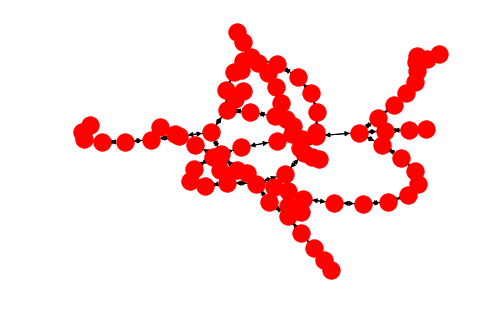

In [173]:
nx.draw(G_rail)

### Tests for the validity of the rail graph

In [174]:
#nx.connected_components(G_rail)
#G_rail.subgraph(c) for c in nx.connected_components(G_rail):
#largest_cc = max(nx.connected_components(G_rail), key=len)

#nx.is_strongly_connected(G_rail)
#largest_cc = max(nx.connected_components(G_rail), key=len)

# this is a test to export a shapefile for testing
list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_rail)))
sz = 0
largest_G = list_of_Gs[0]
count = 0
for g in list_of_Gs:
    curSize = g.size()
    #print(curSize)
    if curSize > sz:
        largest_G = g
        sz = curSize
    #g_gdf = gn.edge_gdf_from_graph(g,crs = {'init' :'epsg:32643'})
    g_gdf = gn.edge_gdf_from_graph(g,crs = {'init' :'epsg:32643'})
    # for some reason has both a geom and geometry column
    g_gdf = g_gdf.drop(columns=['geom'])
    #print(g_gdf)
    filename = 'g_rail_gdf3_%d.shp' % count
    #print(filename)
    g_gdf.to_file(driver = 'ESRI Shapefile', filename = filename )
    count += 1
    #print(count)
#G_rail_largest = largest_G
#G_rail_largest

In [175]:
gn.example_node(G_rail, 3)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f9c649729e8>})
(1, {'x': 272366.8491270583, 'y': 2097048.817394499, 'geom': <shapely.geometry.point.Point object at 0x7f9c64972cf8>})
(3, {'x': 272508.9179740083, 'y': 2097844.3993548118, 'geom': <shapely.geometry.point.Point object at 0x7f9c631a8ba8>})


### Need to convert the graph node coordinates from UTM to WGS84

In [176]:
import importlib
importlib.reload(gn)

<module 'GOSTnet' from '/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets/GOSTnet.py'>

In [177]:
from shapely.geometry import Point
sample_point = Point(271620.51371866115,2101816.267494734)

from shapely.ops import transform
from functools import partial
import pyproj

project_WGS_UTM = partial(
                pyproj.transform,
                pyproj.Proj(init='epsg:32643'),
                pyproj.Proj(init='epsg:4326'))

print(transform(project_WGS_UTM,sample_point))

POINT (72.8305819 18.996213)


In [178]:
G_rail_32643 = gn.reproject_graph(G_rail, 'epsg:32643', 'epsg:4326')

In [179]:
G_rail_32643
gn.example_node(G_rail, 8)

(0, {'x': 72.8360633305759, 'y': 18.940975234799453, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8e10>})
(1, {'x': 72.83822328429102, 'y': 18.95323998167732, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8dd8>})
(3, {'x': 72.83947921893387, 'y': 18.960440822411584, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8e80>})
(4, {'x': 72.8435321130054, 'y': 19.017516410491485, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8f98>})
(5, {'x': 72.8376614, 'y': 19.0094817, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8d68>})
(7, {'x': 72.84434387789514, 'y': 18.96732091413225, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8e48>})
(9, {'x': 72.84414412090767, 'y': 18.978120836025376, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8f28>})
(11, {'x': 72.8440871427147, 'y': 18.987273139187, 'geom': <shapely.geometry.point.Point object at 0x7f9c547b8ef0>})


#### You can see that the coordinates of the road network are already in WGS84

In [180]:
gn.example_node(G, 3)

(2248802304, {'osmid': 2248802304, 'y': 19.0543562, 'x': 72.9334716})
(2231177689, {'osmid': 2231177689, 'y': 19.1347279, 'x': 72.7938162})
(1184044163, {'osmid': 1184044163, 'y': 19.1894556, 'x': 72.9630511})


In [181]:
gn.example_edge(G, 3)

(2248802304, 2248802330, {'osmid': 215438684, 'oneway': False, 'length': 66.863, 'highway': 'residential', 'time': 17.797089689541174, 'mode': 'drive'})
(2231177689, 2231177714, {'osmid': 50889068, 'highway': 'unclassified', 'name': 'Killeshwar Mahadev Mandir Marg', 'oneway': False, 'length': 75.801, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c56b51208>, 'time': 20.176139203399647, 'mode': 'drive'})
(2231177689, 2231177588, {'osmid': 213417598, 'highway': 'unclassified', 'oneway': False, 'length': 290.38200000000006, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c574ec208>, 'time': 77.29169343625544, 'mode': 'drive'})


## Set the rail speed and station wait time, and speeds for roads and walking

In [182]:
print('print inR.crs')
print(inR.crs['init'])

#inR = inR.to_crs({'init': 'epsg:4326'})

list_of_Gs = list((nx.strongly_connected_component_subgraphs(G)))
sz = 0
largest_G = list_of_Gs[0]
for g in list_of_Gs:
    curSize = g.size()
    if curSize > sz:
        largest_G = g
        sz = curSize
G = largest_G
print('print G')
print(sz)

print('print G_rail size')
print(G_rail.size())

#os.remove(outComboGraph)
#if not os.path.exists(outComboGraph):
##Required parameters in processing rail network
metroSpeed = 35 #kph
railSpeed = 40 #kph
station_wait = 30 #seconds
walk_speed = 5 #kph

print inR.crs
epsg:32643
print G
67116
print G_rail size
182


In [183]:
#Convert Rail network length to time
for u, v, data in G_rail.edges(data=True):
    data['mode'] = 'rail'
    data['time'] = 999999999 # driving time
    data['walk_time'] = 999999999 # walking time
    if data['rail_type'] == "metro":
        #print(data['rail_type'])
        data['rail_time'] = ((data['length']/1000 / metroSpeed) * 60 * 60) + station_wait
        # the best time on the rail edges will be the rail times
        data['road_and_rail_time'] = data['rail_time']
    else:
        #print(data['rail_type'])
        data['rail_time'] = ((data['length']/1000 / railSpeed) * 60 * 60) + station_wait
        # the best time on the rail edges will be the rail times
        data['road_and_rail_time'] = data['rail_time']

In [184]:
#Convert Road network length to time
for u, v, data in G.edges(data=True):
    data['mode'] = 'road'
    #Set the rail_time to walking time for the road network
    data['rail_time'] = ((data['length']/1000 / walk_speed) * 60 * 60)
    # the best time on the road edges will be the road times
    data['road_and_rail_time'] = data['time']
    data['walk_time'] = ((data['length']/1000 / walk_speed) * 60 * 60)

# merge the rail and road networks together

In [185]:
# Bind the graphs together
# There was problem with this originally. It seems like the GOSTNets function needs the input graphs to be in 4326
# but G_rail was in UTM

# join_networks will join the networks where the rail nodes (which are the stations) meet the road network nodes within the threshold
#G_combo = gn.join_networks(G, G_rail, measure_crs=32643, thresh=300)
G_combo = gn.join_networks(G_rail,G,measure_crs=32643, thresh=300)
nx.write_gpickle(G_combo, outComboGraph)
#else:
#    G_combo = nx.read_gpickle(outComboGraph)
    
#Extract largest subgraph
list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_combo)))
sz = 0
largest_G = list_of_Gs[0]
for g in list_of_Gs:
    curSize = g.size()
    if curSize > sz:
        largest_G = g
        sz = curSize
G_combo = largest_G
print('print G_combo size')
print(sz)

print G_combo size
71038


#### Inspect the output of the combo graph

In [186]:
G_combo
i = list(G_combo.edges(data = True))[66700]
i

(24975,
 19309,
 {'osmid': 102519587,
  'highway': 'service',
  'oneway': False,
  'length': 238.499,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f9c5260fdd8>,
  'time': 63.481867308763896,
  'mode': 'road',
  'rail_time': 171.71928000000003,
  'road_and_rail_time': 63.481867308763896,
  'walk_time': 171.71928000000003})

In [187]:
# inspect G_combo
g_combo_gdf = gn.edge_gdf_from_graph(G_combo,crs = {'init' :'epsg:4326'})
# for some reason has both a geom and geometry column
g_combo_gdf = g_combo_gdf.drop(columns=['geom','osmid','junction', 'ref','lanes', 'bridge',
       'maxspeed', 'width', 'access','Wkt', 'infra_type','time', 'road_and_rail_time', 'rail_time',
       'highway', 'oneway', 'service', 'length', 'name', 'mode', 'tunnel'])
#print(g_combo_gdf.keys())
#print(g_combo_gdf)
#filename = 'g_gdf_%d.shp' % count
#print(filename)
g_combo_gdf.to_file(driver = 'ESRI Shapefile', filename = inputFolder + '/g_combo5.shp' )

## Run analysis 1 - Distance from each individual to work

In [188]:
inH = pd.read_csv(inHouseholds)
inH[:5]
print(len(inH))

3020


In [189]:
inH.keys()

Index(['unique_respondent', 'gps_latitude_home', 'gps_longitude_home',
       'work_pin_code'],
      dtype='object')

In [190]:
# Group the data frame by id and item
householdLocations = pd.DataFrame(inH.groupby(
   ['unique_respondent']
).agg(
    {
         'gps_latitude_home':"mean",    # Sum duration per group
         'gps_longitude_home': "mean",
         'work_pin_code': "first"
    }
))

In [191]:
householdLocations[:3]

,gps_latitude_home,gps_longitude_home,work_pin_code
unique_respondent,,,
1011,18.909705,72.813837,400005
1021,18.909766,72.813820,400064
1031,18.909751,72.813732,400005


In [192]:
len(householdLocations)

3020

In [193]:
hh = householdLocations

### create a geodataframe of the households and snap to the combo graph

In [194]:
hh['geometry'] = hh.apply(lambda x: Point(x['gps_longitude_home'], x['gps_latitude_home']), axis=1)
hh = gpd.GeoDataFrame(hh, geometry="geometry")
hh.crs = {'init': 'epsg:4326'}
hh = hh.reset_index()
hh = hh[[x.is_valid for x in hh['geometry']]]

# look into warning below
# snapping each individual location to the combo graph
# add walking time to get from household to nearest point in graph, by default 'add_dist_to_node_col = True'
# the source_crs should be the same proj as both the input graph and input geodataframe of points
# hh_nn = gn.pandana_snap(G_combo, hh)
hh_nn = gn.pandana_snap(G_combo, hh, target_crs = 'epsg:32643')

/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets/GOSTnet.py:1716: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/home/vagrant/repos/GOST_PublicGoods/GOSTNets/GOSTNets/GOSTnet.py:1718: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [195]:
hh_nn[:3]

,unique_respondent,gps_latitude_home,gps_longitude_home,work_pin_code,geometry,NN,NN_dist
0,1011,18.909705,72.813837,400005,POINT (72.81383700000001 18.909705),24983,19.906592
1,1021,18.909766,72.813820,400064,POINT (72.81381999999999 18.909766),24983,18.127978
2,1031,18.909751,72.813732,400005,POINT (72.813732 18.909751),24983,8.707958


In [196]:
hh_nn = hh_nn[['unique_respondent','work_pin_code','NN_dist','NN', 'gps_latitude_home', 'gps_longitude_home']]
hh_nn.columns = ['unique_respondent', 'PIN','walk_dist_to_nn','hhNN', 'hhlat', 'hhlon']

### add walking speed to the nearest node

In [197]:
walk_speed = 5 #kph
# generating walk time in seconds
hh_nn['walk_time_to_nn'] = hh_nn['walk_dist_to_nn'] / 1000 / walk_speed * 3600

In [198]:
hh_nn[:3]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn
0,1011,400005,19.906592,24983,18.909705,72.813837,14.332746
1,1021,400064,18.127978,24983,18.909766,72.813820,13.052144
2,1031,400005,8.707958,24983,18.909751,72.813732,6.269730


In [239]:
# Get nodes for the input admin
# snapping the employment by PIN centroids to the combo graph
det_nn = gn.pandana_snap(G_combo, inJ_cen_by_pin)
det_nn[:3]
# for the destination nodes the nearest node distance will be disregarded, because the destinations are centroids 
# and inherently not precise, adding a walking time to the centroid will not add any value to the analysis

,NAME_2,PIN,geometry,NN,NN_dist
0,Greater Bombay,0,POINT (72.96943284769529 19.1798709108074),3216,0.000321
1,Greater Bombay,400005,POINT (72.81558260090947 18.90786843611552),14178,0.000408
2,Greater Bombay,400021,POINT (72.82371588197657 18.92448769713017),14883,0.000338


In [200]:
det_nn = det_nn[['PIN', 'NN', 'geometry']]
det_nn_gpd = gpd.GeoDataFrame(det_nn, geometry='geometry')
det_nn_gpd['detlat'] = det_nn_gpd['geometry'].y
det_nn_gpd['detlon'] = det_nn_gpd['geometry'].x
det_nn_gpd.columns = ['PIN', "detNN", "geometry", "detlat", "detlon"]

print('det_nn count')
print(len(det_nn_gpd.index))

det_nn count
107


In [201]:
det_nn_gpd[:4]

,PIN,detNN,geometry,detlat,detlon
0,0,3216,POINT (72.96943284769529 19.1798709108074),19.179871,72.969433
1,400005,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583
2,400021,14883,POINT (72.82371588197657 18.92448769713017),18.924488,72.823716
3,400039,11690,POINT (72.82977080668174 18.92444826663544),18.924448,72.829771


In [202]:
det_nn_gpd.keys()

Index(['PIN', 'detNN', 'geometry', 'detlat', 'detlon'], dtype='object')

In [203]:
# to make sure PIN is unique, get rid of '0' rows.
det_nn_gpd = det_nn[det_nn['PIN'] != 0]

In [204]:
det_nn_gpd[:4]

,PIN,detNN,geometry,detlat,detlon
1,400005,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583
2,400021,14883,POINT (72.82371588197657 18.92448769713017),18.924488,72.823716
3,400039,11690,POINT (72.82977080668174 18.92444826663544),18.924448,72.829771
4,400032,21306,POINT (72.82565902971034 18.92695446518702),18.926954,72.825659


In [205]:
# Combine Data
# The default is 'inner', which is like a SQL inner join, which selects all rows from both tables as long as there is a match between the columns
# In this case, only the rows that contain PIN values that are common between hh_nn and det_nn remain in the merged data
# This can explain how there are less rows after the merge, for example the certain PIN values don't exist in the PIN centroids dataset
comboData = pd.merge(hh_nn, det_nn_gpd, on='PIN')

print('comboData count')
print(len(comboData.index))

comboData count
2960


In [206]:
comboData[:3]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn,detNN,geometry,detlat,detlon
0,1011,400005,19.906592,24983,18.909705,72.813837,14.332746,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583
1,1031,400005,8.707958,24983,18.909751,72.813732,6.269730,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583
2,1041,400005,46.033518,6352,18.909460,72.814240,33.144133,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583


In [207]:
# Driving, Rail, and Driving & Rail distance from the individual to their workplace
drive_Vals = []
rail_Vals = []
drive_and_rail_Vals = []
walk_Vals = []
euclidean_Vals = []
for idx, row in comboData.iterrows():
    distance1 = nx.shortest_path_length(G_combo, row['hhNN'], row['detNN'], weight='time') + row['walk_time_to_nn']
    drive_Vals.append(distance1)
comboData['driveToWork'] = drive_Vals
for idx, row in comboData.iterrows():
    distance2 = nx.shortest_path_length(G_combo, row['hhNN'], row['detNN'], weight='rail_time') + row['walk_time_to_nn']
    rail_Vals.append(distance2)
comboData['railToWork'] = rail_Vals
for idx, row in comboData.iterrows():
    distance3 = nx.shortest_path_length(G_combo, row['hhNN'], row['detNN'], weight='road_and_rail_time') + row['walk_time_to_nn']
    drive_and_rail_Vals.append(distance3)
comboData['DriveandRailToWork'] = drive_and_rail_Vals
for idx, row in comboData.iterrows():
    distance4 = nx.shortest_path_length(G_combo, row['hhNN'], row['detNN'], weight='walk_time') + row['walk_time_to_nn']
    walk_Vals.append(distance4)
comboData['WalkToWork'] = walk_Vals
for idx, row in comboData.iterrows():
    #returns in km
    euclidean_distance = gn.euclidean_distance(row['hhlat'], row['hhlon'], row['detlat'], row['detlon'])
    euclidean_Vals.append(euclidean_distance)
comboData['euclidean_distance_km'] = euclidean_Vals

In [208]:
comboData[:5]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn,detNN,geometry,detlat,detlon,driveToWork,railToWork,DriveandRailToWork,WalkToWork,euclidean_distance_km
0,1011,400005,19.906592,24983,18.909705,72.813837,14.332746,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583,186.442259,528.723066,186.442259,528.723066,0.274461
1,1031,400005,8.707958,24983,18.909751,72.813732,6.269730,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583,178.379243,520.660050,178.379243,520.660050,0.285683
2,1041,400005,46.033518,6352,18.909460,72.814240,33.144133,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583,171.176916,455.356453,171.176916,455.356453,0.226280
3,2011,400005,37.877030,19331,18.941155,72.832300,27.271462,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583,734.945936,3052.389302,734.945936,3052.389302,4.095184
4,3011,400005,35.423199,8741,18.915563,72.828682,25.504703,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583,390.380487,1359.189503,390.380487,1359.189503,1.620961


In [209]:
comboData.to_csv(inHouseholds.replace(".csv", "_all_Distances_peak_speed.csv"))

In [210]:
xx = pd.merge(inH, comboData, on='unique_respondent', how='left')
xx.to_csv(inHouseholds.replace(".csv", "_all_Distances_merged_peak_speed.csv"))

## Run analysis 2 - household access index

In [211]:
#len(hh_nn)

In [212]:
#hh_nn[:3]

In [213]:
#Identify the originNodes
#hh_nn = gn.pandana_snap(G_combo, hh)

In [214]:
#originNodes = hh_nn

In [246]:
hh_nn[:6]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn
0,1011,400005,19.906592,24983,18.909705,72.813837,14.332746
1,1021,400064,18.127978,24983,18.909766,72.813820,13.052144
2,1031,400005,8.707958,24983,18.909751,72.813732,6.269730
3,1041,400005,46.033518,6352,18.909460,72.814240,33.144133
4,2011,400005,37.877030,19331,18.941155,72.832300,27.271462
5,2021,400002,38.886073,19331,18.941184,72.832227,27.997972


In [247]:
hh_nn.columns = ['unique_respondent', 'PIN','walk_dist_to_nn','NN', 'hhlat', 'hhlon','walk_time_to_nn']

In [248]:
hh_nn[:6]

,unique_respondent,PIN,walk_dist_to_nn,NN,hhlat,hhlon,walk_time_to_nn
0,1011,400005,19.906592,24983,18.909705,72.813837,14.332746
1,1021,400064,18.127978,24983,18.909766,72.813820,13.052144
2,1031,400005,8.707958,24983,18.909751,72.813732,6.269730
3,1041,400005,46.033518,6352,18.909460,72.814240,33.144133
4,2011,400005,37.877030,19331,18.941155,72.832300,27.271462
5,2021,400002,38.886073,19331,18.941184,72.832227,27.997972


In [249]:
#len(originNodes)

In [250]:
det_nn_gpd[:6]

,PIN,detNN,geometry,detlat,detlon
1,400005,14178,POINT (72.81558260090947 18.90786843611552),18.907868,72.815583
2,400021,14883,POINT (72.82371588197657 18.92448769713017),18.924488,72.823716
3,400039,11690,POINT (72.82977080668174 18.92444826663544),18.924448,72.829771
4,400032,21306,POINT (72.82565902971034 18.92695446518702),18.926954,72.825659
5,400023,9027,POINT (72.83235440101836 18.92906961210032),18.929070,72.832354
6,400020,21394,POINT (72.82708919731954 18.93358235888973),18.933582,72.827089


In [251]:
#len(originNodes)

In [252]:
#inJ_cen_by_section[:2]

In [256]:
list(hh_nn['NN'][:3])

[24983, 24983, 24983]

In [257]:
#inJ_cen_by_section.TOTAL_WORKERS.sum()

In [258]:
originNodes = list(hh_nn['NN'])

In [259]:
#Identify destinationNodes
det_nn_section = gn.pandana_snap(G_combo, inJ_cen_by_section)

In [260]:
det_nn_section[:3]

,WARD_ID,WARD_NO,NAME,MUNI_WARD,C_CODE11,CITY,STATE_UT,TOT_HH,TOT_POP,M_POP,...,M_NNW,F_NNW,geometry,section,TOTAL_WORKERS,male_num,female_num,Number of units,NN,NN_dist
0,74,74,Greater Mumbai (M Corp.) (Part) WARD NO.-1874,R NORTH,27518999998027941874,Greater Mumbai,Maharashtra,36517,154540,81975,...,33880,59607,POINT (72.86367396993295 19.26007731432633),74,24891,21104,3787,"8,523",21887,0.000410
1,71,71,Greater Mumbai (M Corp.) (Part) WARD NO.-1771,R CENTRAL,27518999998027941771,Greater Mumbai,Maharashtra,1382,6060,3332,...,1284,1726,POINT (72.80193715484089 19.23995946389579),71,908,685,223,544,23593,0.021754
2,72,72,Greater Mumbai (M Corp.) (Part) WARD NO.-1772,R CENTRAL,27518999998027941772,Greater Mumbai,Maharashtra,21044,91245,48006,...,19465,35022,POINT (72.86037885584142 19.22328990277008),72,19323,15917,3406,"5,468",25807,0.001097


In [261]:
#destNodes = list(det_nn_section['detNN'])
destNodes = det_nn_section['NN'].unique()
#originNodes
#destNodes

In [262]:
# Calculate OD matrix
# for the output matrices the order of the orgins and destinations are preserved
od_driving = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='time')

In [263]:
od_rail = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='rail_time')
od_driving_and_rail = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='road_and_rail_time')

In [265]:
# Calculate the gravity weighted jobs access for driving & rail, as well as for total workers, male, and female)
# note that the origins do not have weights in this scenario
hh_out = hh_nn.copy()

originWeights = 1

# dist_decay represents a half-life of 1 hour
dist_decay = .00019
decayFunction = lambda x: np.exp(-1 * dist_decay * x)


for odType in ['driving', 'rail', 'od_driving_and_rail']:
    od = od_driving
    if odType == "rail":
        od = od_rail
    if odType == "od_driving_and_rail":
        od = od_driving_and_rail
    for weightColumn in ['TOTAL_WORKERS','male_num','female_num']:
        for travel_time in [1800,3600,5400]:
        
            destWeights = det_nn_section[weightColumn]
            #print(destWeights)
            # I think we should normalize the destination weights using min-max normalization
            destWeights_normalized = destWeights.copy()
            destWeights_normalized = (destWeights_normalized - destWeights_normalized.min())/(destWeights.max()-destWeights.min())

            normalized_OD = od

            # this zeros out the outOD matrix
            outOD = od * 0

            for row in range(0, od.shape[0]):
                curRow = normalized_OD[row,:]
                decayedRow = decayFunction(curRow)
                weightedRow = decayedRow * destWeights_normalized * originWeights
                outOD[row,:] = weightedRow

            # Calculate the origin sum weights for each node
            weightedDistance = np.sum(outOD, axis=1)

            resultweights = pd.DataFrame([originNodes, weightedDistance]).transpose()
            colName = "%s_%s_%s" % (odType, weightColumn, travel_time)
            resultweights.columns = ['NN', colName]
            hh_out = pd.merge(hh_out, resultweights, on="NN")
        
hh_out.to_csv(os.path.join(inputFolder, "weighted_distance_all_JOBS_peak_speed.csv"))

MemoryError: 

## Run analysis 3 - number of jobs available within household

In [ ]:
hh_out2 = hh_nn.copy()

for odType in ['driving', 'rail', 'od_driving_and_rail']:
    od = od_driving
    if odType == "rail":
        od = od_rail
    if odType == "od_driving_and_rail":
        od = od_driving_and_rail
    for weightColumn in ['TOTAL_WORKERS','male_num','female_num']:
        for travel_time in [1800,3600,5400]:
        
            jobs_number_series = det_nn_section[weightColumn]

            jobOD = np.where(od <= travel_time, 1, 0)

            jobs_accessible = jobs_number_series.values * jobOD

            jobs_accessible_per_hh = np.sum(jobs_accessible, axis=1)

            resultweights2 = pd.DataFrame([originNodes, jobs_accessible_per_hh]).transpose()
            colName = "%s_%s_%s" % (odType, weightColumn, travel_time)
            resultweights2.columns = ['NN', colName]
            #results2[colName] = resultweights2
            hh_out2 = pd.merge(hh_out2, resultweights2, on="NN")
        
hh_out2.to_csv(os.path.join(inputFolder, "total_jobs_accessible_JOBS_peak_speed.csv")) # Calculate the job accessible per household for driving & rail, as well as for total workers, male, and female)
